In [ ]:
# SPARRING

In [3]:
# Importing Required Packages

import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [44]:
K=6         # No. of arms

# UNCOMMENT OUT THE REQUIRED EXPECTED-VALUE DISTRIBUTION OF THE ARMS
# 1GOOD
alphas = [80]+[5]*(K-1)

# 2GOOD
#alphas = [80, 140/3]+[5]*(K-2)

# 3GOOD
#alphas = [80, 140/3, 140/3]+[5]*(K-3)

# ARITH
#alphas = [80, 140/3, 460/17, 180/11, 260/27, 5]

# GEOM
# alphas = [80, 140/3, 1280/61, 3740/313, 2740/363, 5]

betas = [20]*K

In [45]:
# Arm expectations of the beta distributions generated from above alphas and betas
exp = [alphas[i]/(alphas[i]+betas[i]) for i in range(K)]

In [46]:
# OOPS Class Implementation of SBM

class SBM:
    global K
    def __init__(self):

        self.sumreward = np.zeros(K)    # Sum of observed utilities of K arms
        self.mu = np.ones(K)*np.inf     # Average reward estimates of arms so far
        self.t = np.zeros(K)            # To store no. of times arm is picked
        
        self.x = 0                      # Stores next arm from invoking "advance"
        self.u = 0                      # Stores (unobserved) utility from playing actions

        self.obs_feedback = 0

    def reset(self):
        self.__init__()

    def advance(self, iter):
        alpha = 0.2                 # Parameter for UCB algorithm

        # Picking next arm according to UCB
        if all(self.t):
            self.x = np.argmax([self.mu[k]+np.sqrt((alpha+2)*np.log(iter)/(2*self.t[k])) for k in range(K)])
        else:
            self.x = np.argmax(self.mu)

    # Playing action according to UCB and receiving utility
    def play(self):
        #self.u = np.random.beta(alphas[self.x], betas[self.x])     # Beta distributed values from arms
        self.u = exp[self.x]                                        # Fixed values from arms (expectations of the beta dists)

        self.t[self.x] += 1

    # Feeding back the observed choice variable and updating the SBM reward estimates
    def feedback(self, b):
        
        self.sumreward[self.x] += b
        self.mu[self.x] = self.sumreward[self.x]/self.t[self.x]

        self.obs_feedback = b


# LINK FUNCTIONS
def linear(ut, vt):
    return (1 + vt - ut)/2

def natural(ut, vt):
    return vt/(vt+ut)

def logit(ut, vt):
    return 1/(1+np.exp(ut-vt))

# Returns choice variable by taking in u_t, v_t utility values
def bt(ut, vt):
    prob_yt = linear(ut, vt)            # CHANGE THE LINK FUNCTION HERE!
    prob_xt = 1 - prob_yt
    b = np.random.choice(a=[0,1], p=[prob_xt, prob_yt])
    return b

In [47]:
# Using 50 runs and 32000 time steps

num_runs = 50
regret_array=[]

# SPARRING ALGORITHM

for run in range(num_runs):
    step_regrets = []
    num_iter = 32000

    SL = SBM()
    SR = SBM()

    SL.reset()
    SR.reset()

    for i in range(1,num_iter+1):
        SL.advance(i)
        SR.advance(i)
        
        SL.play()
        SR.play()

        b = bt(SL.u, SR.u)

        SL.feedback(b = 1-b)
        SR.feedback(b = b)

        step_regrets.append(max([alphas[k]/(alphas[k]+betas[k]) for k in range(K)]) - 0.5*(SL.u+SR.u))

    cum_regrets = np.cumsum(step_regrets)
    regret_array.append(cum_regrets)

In [48]:
# Calculating mean and std.dev of the Sparring runs to plot curve and errorbars

spar_regret_array = np.array(regret_array)

spar_mean = np.mean(spar_regret_array, axis = 0)
spar_std = np.std(spar_regret_array, axis = 0)

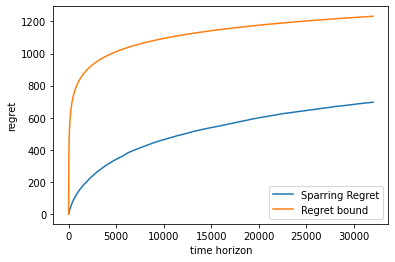

In [43]:
# Plotting simply the linear x-axis plot to show satisfaction of the conjectured regret bound O(logT)

plt.plot(range(1, num_iter+1), spar_mean, label = "Sparring Regret")#, basex = 2)
plt.plot(range(1, num_iter+1), 3*39.6*np.log(range(1, num_iter+1)), label = "Regret bound")#, basex = 2)
plt.xlabel("time horizon")
plt.ylabel("regret")

plt.legend()
plt.show()

In [16]:
# Loading the Interleaved Filter 2 regret data from the .pickle dict file

IF_regret_dict = np.load('Regret_dict_.pickle', allow_pickle=True)

# linear/1good (RUN ONLY THIS SECTION TO GET THESE PLOTS after changing link function and expected arm values and running Sparring)

In [49]:
# Calculating mean and std.dev. of IF2 regrets

if_lin1reg_array = []

for i in range(50):
    if_lin1reg = IF_regret_dict[i]['linear'][0]
    zero_pad = [0]*(num_iter-len(if_lin1reg))
    if_lin1reg += zero_pad
    if_lin1reg = np.cumsum(if_lin1reg)
    if_lin1reg_array.append(if_lin1reg)

if_lin1reg_array = np.array(if_lin1reg_array)
if_l1_mean = np.mean(if_lin1reg_array, axis = 0)
if_l1_std = np.std(if_lin1reg_array, axis = 0)

In [50]:
# Reading Doubler and MultiSBM regrets
# Calculating mean and std.dev. of both for plotting

arr = np.fromfile('doubler_linear_1.csv', sep = ',')
doubler_lin_1_reg = arr.reshape(32766, 50)
doubler_lin_1_reg = np.cumsum(doubler_lin_1_reg, axis = 0)

doubler_lin_1_mean = np.mean(doubler_lin_1_reg, axis = 1)[:num_iter]
doubler_lin_1_std = np.std(doubler_lin_1_reg, axis = 1)[:num_iter]

arr = np.fromfile('multisbm_linear_1.csv', sep = ',')
multi_lin_1_reg = arr.reshape(32000, 50)
multi_lin_1_reg = np.cumsum(multi_lin_1_reg, axis = 0)

multi_lin_1_mean = np.mean(multi_lin_1_reg, axis = 1)
multi_lin_1_std = np.std(multi_lin_1_reg, axis = 1)

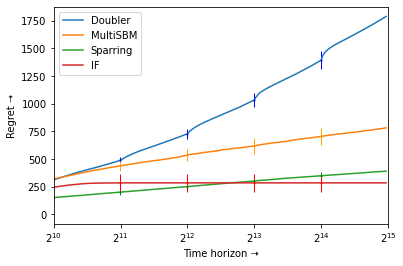

In [51]:
# Plotting the regret curves on semilogx-axis with errorbars

plt.plot(range(1, num_iter+1), doubler_lin_1_mean, label = "Doubler")#, basex = 2)
plt.plot(range(1, num_iter+1), multi_lin_1_mean, label = "MultiSBM")#, basex = 2)
plt.semilogx(range(1, num_iter+1), spar_mean , label = "Sparring", basex = 2)
plt.plot(range(1, num_iter+1), if_l1_mean, label = "IF")
#plt.semilogx(range(1, num_iter+1), 39.6*np.log(range(1, num_iter+1)), basex = 2, label = "Regret bound")

errorbar_points = 2**np.arange(10, 15, 1)-1

plt.errorbar(errorbar_points, doubler_lin_1_mean[errorbar_points], doubler_lin_1_std[errorbar_points], fmt = "bo", linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, multi_lin_1_mean[errorbar_points], multi_lin_1_std[errorbar_points], fmt='o', color = 'orange', linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, spar_mean[errorbar_points], spar_std[errorbar_points], fmt='go', linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, if_l1_mean[errorbar_points], if_l1_std[errorbar_points], fmt='ro', linewidth = 1, markersize=1, capsize=0)

plt.xlim(2**10, 2**15)
plt.xlabel("Time horizon \u279d")
plt.ylabel("Regret \u279d")
plt.legend()
plt.show()

# natural/1good (RUN ONLY THIS SECTION TO GET THESE PLOTS after changing link function and expected arm values and running Sparring)

In [63]:
# Calculating mean and std.dev. of IF2 regrets

if_reg_array = []

for i in range(50):
    if_reg = IF_regret_dict[i]['natural'][0]
    zero_pad = [0]*(num_iter-len(if_reg))
    if_reg += zero_pad
    if_reg = np.cumsum(if_reg)
    if_reg_array.append(if_reg)

if_reg_array = np.array(if_reg_array)
if_mean = np.mean(if_reg_array, axis = 0)
if_std = np.std(if_reg_array, axis = 0)

In [64]:
# Reading Doubler and MultiSBM regrets
# Calculating mean and std.dev. of both for plotting

arr = np.fromfile('doubler_natural_1.csv', sep = ',')
doubler_nat_1_reg = arr.reshape(32766, 50)
doubler_nat_1_reg = np.cumsum(doubler_nat_1_reg, axis = 0)

doubler_nat_1_mean = np.mean(doubler_nat_1_reg, axis = 1)[:num_iter]
doubler_nat_1_std = np.std(doubler_nat_1_reg, axis = 1)[:num_iter]

arr = np.fromfile('multisbm_natural_1.csv', sep = ',')
multi_nat_1_reg = arr.reshape(32000, 50)
multi_nat_1_reg = np.cumsum(multi_nat_1_reg, axis = 0)

multi_nat_1_mean = np.mean(multi_nat_1_reg, axis = 1)
multi_nat_1_std = np.std(multi_nat_1_reg, axis = 1)

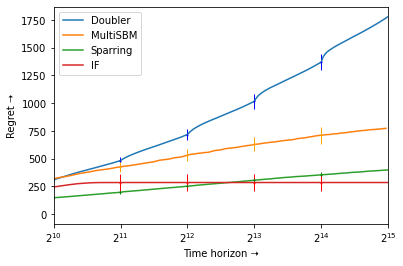

In [67]:
# Plotting the regret curves on semilogx-axis with errorbars

plt.plot(range(1, num_iter+1), doubler_nat_1_mean, label = "Doubler")#, basex = 2)
plt.plot(range(1, num_iter+1), multi_nat_1_mean, label = "MultiSBM")#, basex = 2)
plt.semilogx(range(1, num_iter+1), spar_mean , label = "Sparring", basex = 2)
plt.plot(range(1, num_iter+1), if_mean, label = "IF")
#plt.semilogx(range(1, num_iter+1), 39.6*np.log(range(1, num_iter+1)), basex = 2, label = "Regret bound")

errorbar_points = 2**np.arange(10, 15, 1)-1

plt.errorbar(errorbar_points, doubler_nat_1_mean[errorbar_points], doubler_nat_1_std[errorbar_points], fmt = "bo", linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, multi_nat_1_mean[errorbar_points], multi_nat_1_std[errorbar_points], fmt='o', color = 'orange', linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, spar_mean[errorbar_points], spar_std[errorbar_points], fmt='go', linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, if_mean[errorbar_points], if_std[errorbar_points], fmt='ro', linewidth = 1, markersize=1, capsize=0)

plt.xlim(2**10, 2**15)
plt.xlabel("Time horizon \u279d")
plt.ylabel("Regret \u279d")
plt.legend()
plt.show()

# logit/1good (RUN ONLY THIS SECTION TO GET THESE PLOTS after changing link function and expected arm values and running Sparring)

In [71]:
# Calculating mean and std.dev. of IF2 regrets

if_reg_array = []

for i in range(50):
    if_reg = IF_regret_dict[i]['logit'][0]
    zero_pad = [0]*(num_iter-len(if_reg))
    if_reg += zero_pad
    if_reg = np.cumsum(if_reg)
    if_reg_array.append(if_reg)

if_reg_array = np.array(if_reg_array)
if_mean = np.mean(if_reg_array, axis = 0)
if_std = np.std(if_reg_array, axis = 0)

In [72]:
# Reading Doubler and MultiSBM regrets
# Calculating mean and std.dev. of both for plotting

arr = np.fromfile('doubler_logit_1.csv', sep = ',')
doubler_reg = arr.reshape(32766, 50)
doubler_reg = np.cumsum(doubler_reg, axis = 0)

doubler_mean = np.mean(doubler_reg, axis = 1)[:num_iter]
doubler_std = np.std(doubler_reg, axis = 1)[:num_iter]

arr = np.fromfile('multisbm_logit_1.csv', sep = ',')
multi_reg = arr.reshape(32000, 50)
multi_reg = np.cumsum(multi_reg, axis = 0)

multi_mean = np.mean(multi_reg, axis = 1)
multi_std = np.std(multi_reg, axis = 1)

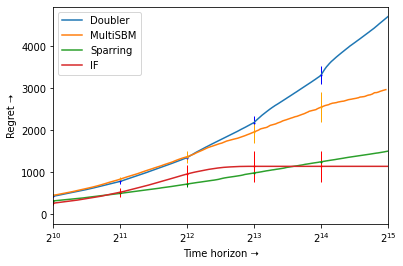

In [73]:
# Plotting the regret curves on semilogx-axis with errorbars

plt.plot(range(1, num_iter+1), doubler_mean, label = "Doubler")#, basex = 2)
plt.plot(range(1, num_iter+1), multi_mean, label = "MultiSBM")#, basex = 2)
plt.semilogx(range(1, num_iter+1), spar_mean , label = "Sparring", basex = 2)
plt.plot(range(1, num_iter+1), if_mean, label = "IF")
#plt.semilogx(range(1, num_iter+1), 39.6*np.log(range(1, num_iter+1)), basex = 2, label = "Regret bound")

errorbar_points = 2**np.arange(10, 15, 1)-1

plt.errorbar(errorbar_points, doubler_mean[errorbar_points], doubler_std[errorbar_points], fmt = "bo", linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, multi_mean[errorbar_points], multi_std[errorbar_points], fmt='o', color = 'orange', linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, spar_mean[errorbar_points], spar_std[errorbar_points], fmt='go', linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, if_mean[errorbar_points], if_std[errorbar_points], fmt='ro', linewidth = 1, markersize=1, capsize=0)

plt.xlim(2**10, 2**15)
plt.xlabel("Time horizon \u279d")
plt.ylabel("Regret \u279d")
plt.legend()
plt.show()

# linear/2good (RUN ONLY THIS SECTION TO GET THESE PLOTS after changing link function and expected arm values and running Sparring)

In [79]:
# Calculating mean and std.dev. of IF2 regrets

if_reg_array = []

for i in range(50):
    if_reg = IF_regret_dict[i]['linear'][1]
    zero_pad = [0]*(num_iter-len(if_reg))
    if_reg += zero_pad
    if_reg = np.cumsum(if_reg)
    if_reg_array.append(if_reg)

if_reg_array = np.array(if_reg_array)
if_mean = np.mean(if_reg_array, axis = 0)
if_std = np.std(if_reg_array, axis = 0)

In [81]:
# Reading Doubler and MultiSBM regrets
# Calculating mean and std.dev. of both for plotting

arr = np.fromfile('doubler_linear_2.csv', sep = ',')
doubler_reg = arr.reshape(32766, 50)
doubler_reg = np.cumsum(doubler_reg, axis = 0)

doubler_mean = np.mean(doubler_reg, axis = 1)[:num_iter]
doubler_std = np.std(doubler_reg, axis = 1)[:num_iter]

arr = np.fromfile('multisbm_linear_2.csv', sep = ',')
multi_reg = arr.reshape(32000, 20)
multi_reg = np.cumsum(multi_reg, axis = 0)

multi_mean = np.mean(multi_reg, axis = 1)
multi_std = np.std(multi_reg, axis = 1)

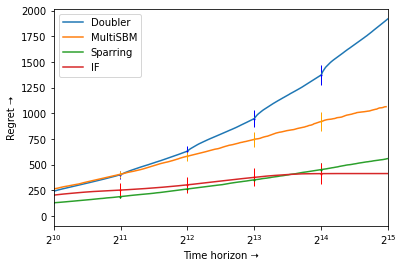

In [86]:
# Plotting the regret curves on semilogx-axis with errorbars

plt.plot(range(1, num_iter+1), doubler_mean, label = "Doubler")#, basex = 2)
plt.plot(range(1, num_iter+1), multi_mean, label = "MultiSBM")#, basex = 2)
plt.semilogx(range(1, num_iter+1), spar_mean , label = "Sparring", basex = 2)
plt.plot(range(1, num_iter+1), if_mean, label = "IF")
#plt.semilogx(range(1, num_iter+1), 39.6*np.log(range(1, num_iter+1)), basex = 2, label = "Regret bound")

errorbar_points = 2**np.arange(10, 15, 1)-1

plt.errorbar(errorbar_points, doubler_mean[errorbar_points], doubler_std[errorbar_points], fmt = "bo", linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, multi_mean[errorbar_points], multi_std[errorbar_points], fmt='o', color = 'orange', linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, spar_mean[errorbar_points], spar_std[errorbar_points], fmt='go', linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, if_mean[errorbar_points], if_std[errorbar_points], fmt='ro', linewidth = 1, markersize=1, capsize=0)

plt.xlim(2**10, 2**15)
plt.xlabel("Time horizon \u279d")
plt.ylabel("Regret \u279d")
plt.legend()
plt.show()

# linear/3good (RUN ONLY THIS SECTION TO GET THESE PLOTS after changing link function and expected arm values and running Sparring)

In [17]:
# Calculating mean and std.dev. of IF2 regrets

if_reg_array = []

for i in range(50):
    if_reg = IF_regret_dict[i]['linear'][2]
    zero_pad = [0]*(num_iter-len(if_reg))
    if_reg += zero_pad
    if_reg = np.cumsum(if_reg)
    if_reg_array.append(if_reg)

if_reg_array = np.array(if_reg_array)
if_mean = np.mean(if_reg_array, axis = 0)
if_std = np.std(if_reg_array, axis = 0)

In [18]:
# Reading Doubler and MultiSBM regrets
# Calculating mean and std.dev. of both for plotting

arr = np.fromfile('doubler_linear_3.csv', sep = ',')
doubler_reg = arr.reshape(32766, 50)
doubler_reg = np.cumsum(doubler_reg, axis = 0)

doubler_mean = np.mean(doubler_reg, axis = 1)[:num_iter]
doubler_std = np.std(doubler_reg, axis = 1)[:num_iter]

arr = np.fromfile('multisbm_linear_3.csv', sep = ',')
multi_reg = arr.reshape(32000, 20)
multi_reg = np.cumsum(multi_reg, axis = 0)

multi_mean = np.mean(multi_reg, axis = 1)
multi_std = np.std(multi_reg, axis = 1)

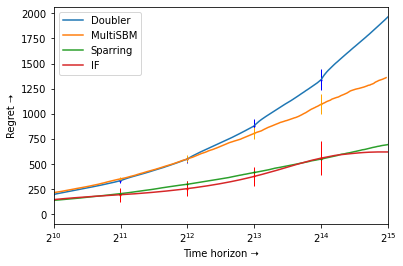

In [19]:
# Plotting the regret curves on semilogx-axis with errorbars

plt.plot(range(1, num_iter+1), doubler_mean, label = "Doubler")#, basex = 2)
plt.plot(range(1, num_iter+1), multi_mean, label = "MultiSBM")#, basex = 2)
plt.semilogx(range(1, num_iter+1), spar_mean , label = "Sparring", basex = 2)
plt.plot(range(1, num_iter+1), if_mean, label = "IF")
#plt.semilogx(range(1, num_iter+1), 39.6*np.log(range(1, num_iter+1)), basex = 2, label = "Regret bound")

errorbar_points = 2**np.arange(10, 15, 1)-1

plt.errorbar(errorbar_points, doubler_mean[errorbar_points], doubler_std[errorbar_points], fmt = "bo", linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, multi_mean[errorbar_points], multi_std[errorbar_points], fmt='o', color = 'orange', linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, spar_mean[errorbar_points], spar_std[errorbar_points], fmt='go', linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, if_mean[errorbar_points], if_std[errorbar_points], fmt='ro', linewidth = 1, markersize=1, capsize=0)

plt.xlim(2**10, 2**15)
plt.xlabel("Time horizon \u279d")
plt.ylabel("Regret \u279d")
plt.legend()
plt.show()

# linear/arith (RUN ONLY THIS SECTION TO GET THESE PLOTS after changing link function and expected arm values and running Sparring)

In [100]:
# Calculating mean and std.dev. of IF2 regrets

if_reg_array = []

for i in range(50):
    if_reg = IF_regret_dict[i]['linear'][3]
    zero_pad = [0]*(num_iter-len(if_reg))
    if_reg += zero_pad
    if_reg = np.cumsum(if_reg)
    if_reg_array.append(if_reg)

if_reg_array = np.array(if_reg_array)
if_mean = np.mean(if_reg_array, axis = 0)
if_std = np.std(if_reg_array, axis = 0)

In [101]:
# Reading Doubler and MultiSBM regrets
# Calculating mean and std.dev. of both for plotting

arr = np.fromfile('doubler_linear_arith.csv', sep = ',')
doubler_reg = arr.reshape(32766, 50)
doubler_reg = np.cumsum(doubler_reg, axis = 0)

doubler_mean = np.mean(doubler_reg, axis = 1)[:num_iter]
doubler_std = np.std(doubler_reg, axis = 1)[:num_iter]

arr = np.fromfile('multisbm_linear_arith.csv', sep = ',')
multi_reg = arr.reshape(32000, 20)
multi_reg = np.cumsum(multi_reg, axis = 0)

multi_mean = np.mean(multi_reg, axis = 1)
multi_std = np.std(multi_reg, axis = 1)

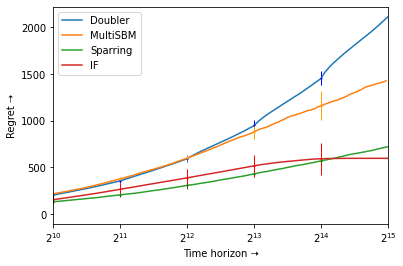

In [102]:
# Plotting the regret curves on semilogx-axis with errorbars

plt.plot(range(1, num_iter+1), doubler_mean, label = "Doubler")#, basex = 2)
plt.plot(range(1, num_iter+1), multi_mean, label = "MultiSBM")#, basex = 2)
plt.semilogx(range(1, num_iter+1), spar_mean , label = "Sparring", basex = 2)
plt.plot(range(1, num_iter+1), if_mean, label = "IF")
#plt.semilogx(range(1, num_iter+1), 39.6*np.log(range(1, num_iter+1)), basex = 2, label = "Regret bound")

errorbar_points = 2**np.arange(10, 15, 1)-1

plt.errorbar(errorbar_points, doubler_mean[errorbar_points], doubler_std[errorbar_points], fmt = "bo", linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, multi_mean[errorbar_points], multi_std[errorbar_points], fmt='o', color = 'orange', linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, spar_mean[errorbar_points], spar_std[errorbar_points], fmt='go', linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, if_mean[errorbar_points], if_std[errorbar_points], fmt='ro', linewidth = 1, markersize=1, capsize=0)

plt.xlim(2**10, 2**15)
plt.xlabel("Time horizon \u279d")
plt.ylabel("Regret \u279d")
plt.legend()
plt.show()

# linear/geom (RUN ONLY THIS SECTION TO GET THESE PLOTS after changing link function and expected arm values and running Sparring)

In [20]:
# Calculating mean and std.dev. of IF2 regrets

if_reg_array = []

for i in range(50):
    if_reg = IF_regret_dict[i]['linear'][4]
    zero_pad = [0]*(num_iter-len(if_reg))
    if_reg += zero_pad
    if_reg = np.cumsum(if_reg)
    if_reg_array.append(if_reg)

if_reg_array = np.array(if_reg_array)
if_mean = np.mean(if_reg_array, axis = 0)
if_std = np.std(if_reg_array, axis = 0)

In [21]:
# Reading Doubler and MultiSBM regrets
# Calculating mean and std.dev. of both for plotting

arr = np.fromfile('doubler_linear_geom.csv', sep = ',')
doubler_reg = arr.reshape(32766, 50)
doubler_reg = np.cumsum(doubler_reg, axis = 0)

doubler_mean = np.mean(doubler_reg, axis = 1)[:num_iter]
doubler_std = np.std(doubler_reg, axis = 1)[:num_iter]

arr = np.fromfile('multisbm_linear_geom.csv', sep = ',')
multi_reg = arr.reshape(32000, 20)
multi_reg = np.cumsum(multi_reg, axis = 0)

multi_mean = np.mean(multi_reg, axis = 1)
multi_std = np.std(multi_reg, axis = 1)

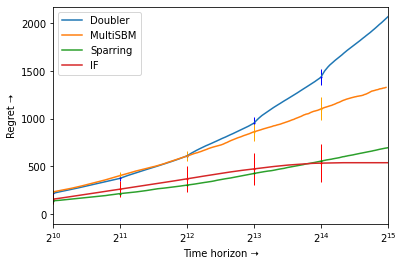

In [35]:
# Plotting the regret curves on semilogx-axis with errorbars

plt.plot(range(1, num_iter+1), doubler_mean, label = "Doubler")#, basex = 2)
plt.plot(range(1, num_iter+1), multi_mean, label = "MultiSBM")#, basex = 2)
plt.semilogx(range(1, num_iter+1), spar_mean , label = "Sparring", basex = 2)
plt.plot(range(1, num_iter+1), if_mean, label = "IF")
#plt.semilogx(range(1, num_iter+1), 39.6*np.log(range(1, num_iter+1)), basex = 2, label = "Regret bound")

errorbar_points = 2**np.arange(10, 15, 1)-1

plt.errorbar(errorbar_points, doubler_mean[errorbar_points], doubler_std[errorbar_points], fmt = "bo", linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, multi_mean[errorbar_points], multi_std[errorbar_points], fmt='o', color = 'orange', linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, spar_mean[errorbar_points], spar_std[errorbar_points], fmt='go', linewidth = 1, markersize=1, capsize=0)
plt.errorbar(errorbar_points, if_mean[errorbar_points], if_std[errorbar_points], fmt='ro', linewidth = 1, markersize=1, capsize=0)

plt.xlim(2**10, 2**15)
plt.xlabel("Time horizon \u279d")
plt.ylabel("Regret \u279d")
plt.legend()
plt.show()